IMPORTACION DE LIBRERIAS

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

CARGA DE ARCHIVOS

In [ ]:
ARCHIVO_MENSUAL = "Consumo_mensual.csv"
ARCHIVO_PROMEDIOS = "Promedio_mensual.csv"

CARGA Y EXPLORACION DE DATOS

In [ ]:
# Cargar el dataset de promedios por barrio
df_promedios = pd.read_csv(ARCHIVO_PROMEDIOS, decimal=',', sep=';')

# Cargar el dataset de consumo mensual
df_mensual = pd.read_csv(ARCHIVO_MENSUAL, decimal=',', sep=';')

# Cargar el dataset de promedios por barrio (para el consumo promedio como Feature)
df_promedios = pd.read_csv(ARCHIVO_PROMEDIOS)

# Cargar el dataset de consumo mensual (para calcular la variabilidad como Feature)
df_mensual = pd.read_csv(ARCHIVO_MENSUAL)

# Renombrar columnas para claridad
df_promedios.rename(columns={'MES': 'Barrio', 'PROMEDIO MENSUAL': 'Consumo_Promedio'}, inplace=True)

print("### Resumen df_promedios (Base para el Clustering) ###")
print(df_promedios.head())
print("\nValores Faltantes:")
print(df_promedios.isnull().sum())
print("-" * 50)

### Resumen df_promedios (Base para el Clustering) ###
         Barrio Consumo_Promedio
0       VINALAR             6,15
1    AEROPUERTO            55,38
2  SAN CAYETANO             8,08
3   VILLA NUEVA             6,33
4     MUNICIPAL             6,67

Valores Faltantes:
Barrio              0
Consumo_Promedio    0
dtype: int64
--------------------------------------------------


LIMPIEZA

In [ ]:
# Limpieza en df_promedios
# Si hay comas que son separadores de miles, debemos quitarlas.
df_promedios['Consumo_Promedio'] = (
    df_promedios['Consumo_Promedio']
    .astype(str) # Convertir a string para usar .str.replace
    .str.replace('.', '', regex=False) # Eliminar puntos (posibles separadores de miles)
    .str.replace(',', '.', regex=False) # Reemplazar coma decimal por punto decimal estándar
    .str.replace(' ', '', regex=False) # Eliminar espacios
)
# Forzar la conversión a numérico. 'errors=coerce' pondrá NaN donde falle.
df_promedios['Consumo_Promedio'] = pd.to_numeric(df_promedios['Consumo_Promedio'], errors='coerce')

FASE DE INGENIERIA

In [ ]:
# Objetivo: Calcular la Desviación Estándar (indicador de variabilidad/inestabilidad)
# Hacemos una transformación del dataset mensual para agrupar por barrio y calcular métricas

# A. Transponer el df_mensual para que cada barrio sea una fila
# Primero, seleccionamos solo las columnas de consumo (asumiendo que las primeras
# columnas son meta-datos y las siguientes son barrios, ajusta los índices si es necesario)
# Usaremos 'CLASIFICACION CONSUMO' como ancla para las columnas que no son barrios
# Identificar las columnas de consumo por barrio en el df_mensual
columnas_no_barrio = ['MES', 'PROMEDIO MENSUAL', 'TOTAL MENSUAL',
                      'VARIACION MENSUAL (%)', 'CLASIFICACION CONSUMO']
columnas_barrio = [col for col in df_mensual.columns if col not in columnas_no_barrio]

# Crear un DataFrame largo (melt) para facilitar la agrupación de barrios
df_largo = df_mensual[['MES'] + columnas_barrio].melt(
    id_vars=['MES'],
    value_vars=columnas_barrio,
    var_name='Barrio',
    value_name='Consumo_Mensual'
)

# **Aseguramos que 'Consumo_Mensual' sea numérico. Si hay aún errores, forzamos.**
# Los errores que aún puedan aparecer aquí serán transformados en NaN para poder continuar.
df_largo['Consumo_Mensual'] = pd.to_numeric(df_largo['Consumo_Mensual'], errors='coerce')


# B. Calcular la Desviación Estándar y el Coeficiente de Variación por Barrio
df_variabilidad = df_largo.groupby('Barrio')['Consumo_Mensual'].agg(
    Desviacion_Estandar=('std'),
    Consumo_Media_Verificacion=('mean')
).reset_index()

# Calcular Coeficiente de Variación (CV): CV = Desviación Estándar / Media
df_variabilidad['Coeficiente_Variacion'] = (
    df_variabilidad['Desviacion_Estandar'] / df_variabilidad['Consumo_Media_Verificacion']
)

# Manejar NaNs (por ejemplo, si la media es cero o si hay datos faltantes)
df_variabilidad.fillna(0, inplace=True)

# (El código del merge, selección de FEATURES y StandardScaler que sigue es el mismo)

df_clustering = pd.merge(
    df_promedios[['Barrio', 'Consumo_Promedio']],
    df_variabilidad[['Barrio', 'Desviacion_Estandar', 'Coeficiente_Variacion']],
    on='Barrio',
    how='inner'
)

FEATURES = ['Consumo_Promedio', 'Desviacion_Estandar', 'Coeficiente_Variacion']
X = df_clustering[FEATURES].copy()

# Imputamos NaNs con la media después del merge
X.fillna(X.mean(), inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

df_scaled = pd.DataFrame(X_scaled, columns=FEATURES, index=df_clustering['Barrio'])

print("\n✅ Verificación: Si no hay error, el dataset escalado está listo.")
print(df_scaled.head())


✅ Verificación: Si no hay error, el dataset escalado está listo.
              Consumo_Promedio  Desviacion_Estandar  Coeficiente_Variacion
Barrio                                                                    
VINALAR              -0.539949             1.714415               0.549846
AEROPUERTO            0.087672            -0.064566              -0.691685
SAN CAYETANO         -0.515344            -0.288415              -0.512388
VILLA NUEVA          -0.537654            -0.322480              -0.545147
MUNICIPAL            -0.533319            -0.402843              -0.984042


DETERMINACION DEL NUMERO DE CLUSTERS OPTIMO

--- Visualización: Método del Codo (WCSS) ---


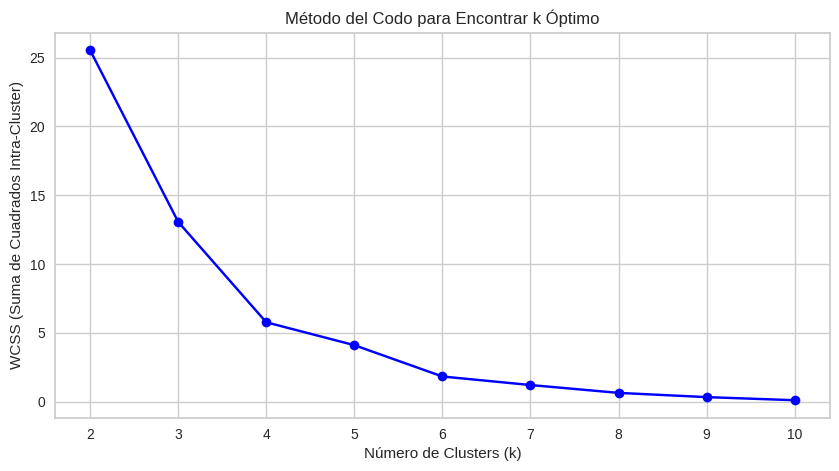


--- Visualización: Puntaje de Silueta ---


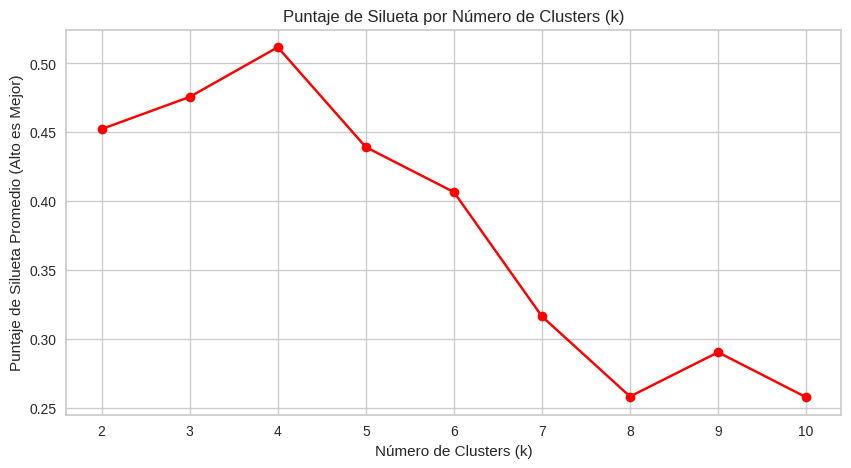


Tabla de Métricas para Análisis:
k   | WCSS            | Silueta   
------------------------------
2   | 25.53           | 0.4524    
3   | 13.06           | 0.4757    
4   | 5.77            | 0.5117    
5   | 4.10            | 0.4393    
6   | 1.83            | 0.4067    
7   | 1.21            | 0.3166    
8   | 0.64            | 0.2585    
9   | 0.33            | 0.2906    
10  | 0.10            | 0.2580    


In [ ]:
# Aseguramos que los datos a usar sean el DataFrame escalado (asumiendo que df_scaled está disponible)
X_data = df_scaled.values
K_RANGE = range(2, 11) # Rango de k a probar

# Inicializar listas para almacenar las métricas
wcss = []
silhouette_scores = []

# Iterar sobre el rango de k
for k in K_RANGE:
    # 1. Entrenar el modelo K-Means
    # n_init=10 asegura que el algoritmo elija la mejor inicialización.
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_data)

    # 2. Calcular WCSS (Within-Cluster Sum of Squares)
    wcss.append(kmeans.inertia_)

    # 3. Calcular Puntaje de Silueta (solo para k > 1)
    # Como K_RANGE comienza en 2, todos los valores son válidos para la silueta
    score = silhouette_score(X_data, kmeans.labels_)
    silhouette_scores.append(score)

# --- 1. Visualización del Método del Codo (WCSS) ---
print("--- Visualización: Método del Codo (WCSS) ---")
plt.figure(figsize=(10, 5))
plt.plot(K_RANGE, wcss, marker='o', linestyle='-', color='blue')
plt.title('Método del Codo para Encontrar k Óptimo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WCSS (Suma de Cuadrados Intra-Cluster)')
plt.xticks(K_RANGE)
plt.grid(True)
plt.show()

# --- 2. Visualización del Puntaje de Silueta ---
print("\n--- Visualización: Puntaje de Silueta ---")
plt.figure(figsize=(10, 5))
# K_RANGE y silhouette_scores ahora tienen el mismo número de elementos (9)
plt.plot(K_RANGE, silhouette_scores, marker='o', linestyle='-', color='red')
plt.title('Puntaje de Silueta por Número de Clusters (k)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Puntaje de Silueta Promedio (Alto es Mejor)')
plt.xticks(K_RANGE)
plt.grid(True)
plt.show()

# Imprimir los valores para análisis detallado
print("\nTabla de Métricas para Análisis:")
print(f"{'k':<3} | {'WCSS':<15} | {'Silueta':<10}")
print("-" * 30)
for k, w, s in zip(K_RANGE, wcss, silhouette_scores):
    print(f"{k:<3} | {w:<15.2f} | {s:<10.4f}")

APLICACION Y PERFILACION DEL MODELO

In [ ]:
# Asumimos que df_scaled y df_clustering están disponibles de las fases anteriores
# (df_scaled contiene los datos escalados para el algoritmo)
X_data = df_scaled.values
N_CLUSTERS = 4 # Valor óptimo determinado

# Entrenamiento final del modelo
kmeans_final = KMeans(n_clusters=N_CLUSTERS, init='k-means++', random_state=42, n_init=10)
kmeans_final.fit(X_data)

# Obtener las etiquetas de cluster asignadas a cada barrio
cluster_labels = kmeans_final.labels_

# Añadir las etiquetas al DataFrame original (no escalado) para la interpretación
df_results = df_clustering.copy()
df_results['Cluster'] = cluster_labels

print("✅ Modelo K-Means entrenado y etiquetas asignadas a los barrios.")
print(df_results)

✅ Modelo K-Means entrenado y etiquetas asignadas a los barrios.
           Barrio  Consumo_Promedio  Desviacion_Estandar  \
0         VINALAR              6.15            53.649254   
1      AEROPUERTO             55.38            12.037819   
2    SAN CAYETANO              8.08             6.801849   
3     VILLA NUEVA              6.33             6.005048   
4       MUNICIPAL              6.67             4.125310   
5   12 DE OCTUBRE            269.92             2.188122   
6       TRIANGULO             20.67             3.700123   
7       PORVERNIR              6.50             1.752920   
8           CANAL             29.69             2.062655   
9      BELGRANO N              6.00             1.213560   
10         CENTRO              9.00            79.653178   
11       BELGRANO             26.46             1.433369   
12     SOR ANGELA            179.69             1.501514   

    Coeficiente_Variacion  Cluster  
0                0.551191        0  
1                0.40

In [ ]:
# Calcular las características promedio de cada cluster
cluster_profile = df_results.groupby('Cluster')[['Consumo_Promedio', 'Desviacion_Estandar', 'Coeficiente_Variacion']].mean().sort_values(by='Consumo_Promedio', ascending=False)

print("\n--- Perfil de Clusters (Valores Promedio por Grupo) ---")
print(cluster_profile)


--- Perfil de Clusters (Valores Promedio por Grupo) ---
         Consumo_Promedio  Desviacion_Estandar  Coeficiente_Variacion
Cluster                                                              
2              224.805000             1.844818               0.551416
3               25.180000             2.881389               0.660479
1               16.488571             4.767125               0.397610
0                7.575000            66.651216               0.547604


PRESENTACION DE RESULTADOS

In [ ]:
# Mapeo de Clusters a Prioridades (basado en la tabla de análisis)
# ¡CRÍTICA es el Cluster 0 por su variabilidad extrema!
prioridad_mapping = {
    0: 'CRÍTICA',
    2: 'ALTA',
    3: 'MEDIA',
    1: 'BAJA'
}

# 1. Asignación de Nivel de Prioridad
# Crear la columna Nivel_de_Prioridad usando el mapeo
df_final_report = df_results.copy()
df_final_report['Nivel_de_Prioridad'] = df_final_report['Cluster'].map(prioridad_mapping)

# 2. Generación del Reporte Final
report_columns = ['Barrio', 'Consumo_Promedio', 'Desviacion_Estandar', 'Coeficiente_Variacion', 'Nivel_de_Prioridad']

# Ordenar por Nivel de Prioridad (CRÍTICA, ALTA, MEDIA, BAJA)
prioridad_orden = ['CRÍTICA', 'ALTA', 'MEDIA', 'BAJA']
df_final_report['Nivel_de_Prioridad'] = pd.Categorical(
    df_final_report['Nivel_de_Prioridad'],
    categories=prioridad_orden,
    ordered=True
)
df_final_report.sort_values(by='Nivel_de_Prioridad', inplace=True)

# 3. Presentación de Resultados
print("\n--- INFORME FINAL DE PRIORIDADES DE BARRIOS ---")
print("Barrios Ordenados por Nivel de Urgencia para Tanque Comunitario:")
print("---------------------------------------------------------------")
print(df_final_report[report_columns].to_markdown(index=False, floatfmt=".2f"))

# 4. Resumen Estadístico por Prioridad
print("\n--- RESUMEN ESTADÍSTICO POR NIVEL DE PRIORIDAD ---")
resumen = df_final_report.groupby('Nivel_de_Prioridad')[['Consumo_Promedio', 'Desviacion_Estandar']].agg(['count', 'mean'])
resumen.columns = ['_'.join(col).strip() for col in resumen.columns.values]
resumen.rename(columns={'Consumo_Promedio_count': 'Cant. Barrios'}, inplace=True)
print(resumen.to_markdown(floatfmt=".2f"))


--- INFORME FINAL DE PRIORIDADES DE BARRIOS ---
Barrios Ordenados por Nivel de Urgencia para Tanque Comunitario:
---------------------------------------------------------------
| Barrio        |   Consumo_Promedio |   Desviacion_Estandar |   Coeficiente_Variacion | Nivel_de_Prioridad   |
|:--------------|-------------------:|----------------------:|------------------------:|:---------------------|
| VINALAR       |               6.15 |                 53.65 |                    0.55 | CRÍTICA              |
| CENTRO        |               9.00 |                 79.65 |                    0.54 | CRÍTICA              |
| 12 DE OCTUBRE |             269.92 |                  2.19 |                    0.66 | ALTA                 |
| SOR ANGELA    |             179.69 |                  1.50 |                    0.45 | ALTA                 |
| TRIANGULO     |              20.67 |                  3.70 |                    0.75 | MEDIA                |
| CANAL         |              29.69 |

/tmp/ipython-input-3613843069.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumen = df_final_report.groupby('Nivel_de_Prioridad')[['Consumo_Promedio', 'Desviacion_Estandar']].agg(['count', 'mean'])


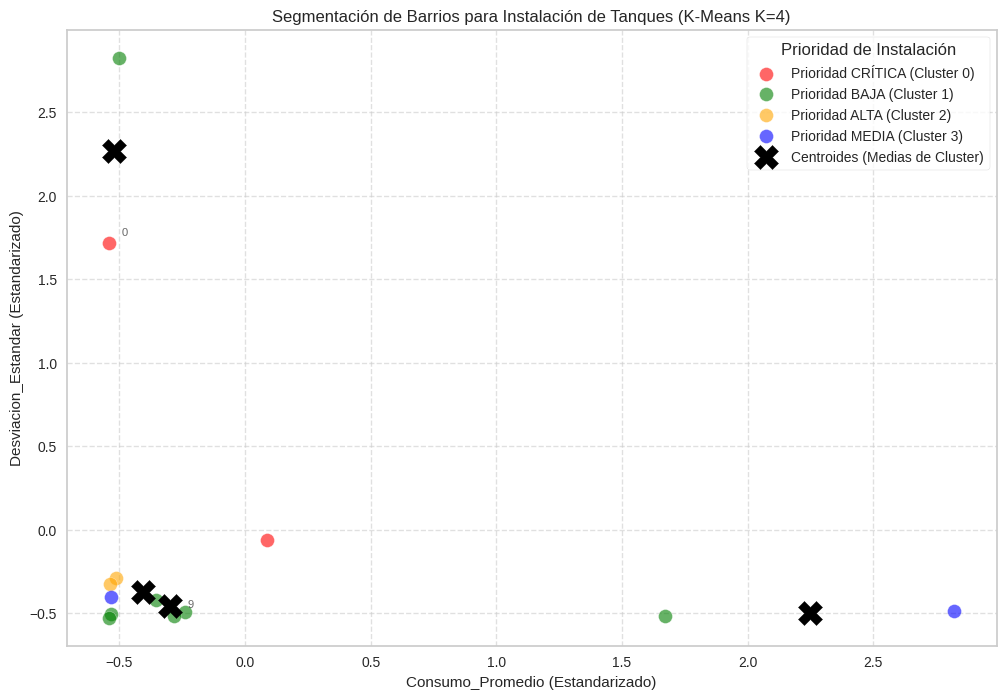

In [ ]:
# --- 1. PREPARACIÓN DE DATOS (Asumo que df_final_report y kmeans_final están disponibles) ---

# Reconstruir el mapeo de colores para el gráfico (es más visual usar colores intensos para alta prioridad)
color_map = {
    'CRÍTICA': 'red',
    'ALTA': 'orange',
    'MEDIA': 'blue',
    'BAJA': 'green'
}

# Obtener las coordenadas de los centros de los clusters (en el espacio ESCALADO)
# Usaremos las coordenadas de las dos primeras features (Consumo_Promedio y Desviacion_Estandar)
cluster_centers_scaled = kmeans_final.cluster_centers_

# --- 2. IDENTIFICAR LAS COLUMNAS EN EL DATAFRAME ESCALADO ---
# Necesitamos la posición de las dos features elegidas para graficar
feature_indices = {
    'Consumo_Promedio': 0, # Primera columna en X_data/df_scaled
    'Desviacion_Estandar': 1 # Segunda columna en X_data/df_scaled
}
X_col = 'Consumo_Promedio'
Y_col = 'Desviacion_Estandar'

# Tomar los datos escalados (X_data) para graficar
X_data = df_scaled.values
cluster_labels = df_final_report['Cluster'].values


# --- 3. GENERACIÓN DEL GRÁFICO DE DISPERSIÓN ---

plt.figure(figsize=(12, 8))
plt.title('Segmentación de Barrios para Instalación de Tanques (K-Means K=4)')
plt.xlabel(f'{X_col} (Estandarizado)')
plt.ylabel(f'{Y_col} (Estandarizado)')

# A. Dibujar los puntos (Barrios)
# Iterar por cada cluster para asignar el color correcto
for cluster_id in np.unique(cluster_labels):
    # Filtrar datos para el cluster actual
    cluster_mask = (cluster_labels == cluster_id)

    # Obtener el Nivel de Prioridad y el color correspondiente
    prioridad = df_final_report[df_final_report['Cluster'] == cluster_id]['Nivel_de_Prioridad'].iloc[0]
    color = color_map[prioridad]

    # Graficar los barrios del cluster
    plt.scatter(
        X_data[cluster_mask, feature_indices[X_col]],
        X_data[cluster_mask, feature_indices[Y_col]],
        s=100, # Tamaño del punto
        c=color,
        alpha=0.6, # Transparencia
        edgecolors='w',
        label=f'Prioridad {prioridad} (Cluster {cluster_id})'
    )

# B. Dibujar los Centros de los Clusters
plt.scatter(
    cluster_centers_scaled[:, feature_indices[X_col]],
    cluster_centers_scaled[:, feature_indices[Y_col]],
    s=300, # Tamaño grande para los centros
    marker='X', # Marcador en forma de 'X'
    c='black',
    label='Centroides (Medias de Cluster)',
    zorder=5 # Asegura que se dibuje por encima de los puntos
)

# C. Añadir las etiquetas de los barrios (opcional pero muy informativo)
for i, barrio in enumerate(df_final_report.index):
    # Solo etiquetar algunos o todos si el dataset es pequeño
    if np.random.rand() < 0.2: # Etiquetar solo un 20% de forma aleatoria para no saturar
        plt.annotate(
            barrio,
            (X_data[i, feature_indices[X_col]] + 0.05, X_data[i, feature_indices[Y_col]] + 0.05),
            fontsize=8,
            alpha=0.7
        )

plt.legend(scatterpoints=1, frameon=True, title="Prioridad de Instalación")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()